# Synaptomes Notebook

In this notebook, we will attempt to cluster large synapse data using the FlashX Gaussian Mixture Model (GMM) code.

# Data

In this experiment, we will utilize 24 channel array tomagraphy data.

The process of collecting array tomography data is relatively straightforward. Brain tissue is embedded with plastic, and this plastic-embedded tissue is then sectioned into ultrathin 2D chunks which can then be imaged using various wavelengths of light with a microscope. After imaging, the 2D sections can be reconstructed to yield a representation of the original 3D object.

Each protein has a unique "protein fluorescence" which gives it a particular color under different light intensities. In this data, we look at 24 different channels of light intensities, corresponding to the fluorescences of 24 proteins we want to look at. We cut out a 10x10x10 voxel cube around putative synapse locations, and for each channel sum the intensities of all 10x10x10 voxels to form a 24-dimensional feature vector for each putative synapse location. 

# Gaussian Mixture Model

Under the gaussian mixture model, we assume that for the $i^{th}$ synapse type, we have a unique set of parameters $\theta_c = \left\{ \mu_c, \Sigma_c \right\}$ describing the mean and covariance of the channel intensities. 

### Data

Let $x \in \mathbb{R}^{n \times d}$ be our arrray-tomography data, where we have $n$ samples with $d$ channels per sample. In this example, we have approximately 1,200,000 samples of 24 channel synapse data.

### Latent Variable

We define $z \in \{0, 1\}^{n \times k}$ to be our latent parameter, where $z_{i, c} = 1$ when the $i^{th}$ point is a synapse of type $c$, and $z_{i, c} = 0$ otherwise. 

### Model Parameters

Define $\pi \in [0, 1]^k$ to be the total probability of a particular synapse type occuring, where $\mu \in \mathbb{R}^{k \times d}$, $\Sigma \in \mathbb{R}^{k \times d \times d}$ are our collections of means and covariances for each of our $k$ synapses with $d$ channels.

Using expectation-maximization, we find that we can solve for $\mu, \Sigma$ by an iterative procedure. First, we compute the expectation $\gamma_{i, c}$ of $z_{i, c}$, or that a particular $x_i$ being explained by the $c^{th}$ channel. Next, we "maximize", by computing the partial derivative with respect to our model parameters $\pi$, $\mu$, and $\Sigma$ and solving given the expectations $\gamma$.

# Example

In the below example, we show that FlashGraphR significantly outperforms the popular [mclust](https://cran.r-project.org/web/packages/mclust/mclust.pdf) package, a common package for mixture modeling in R on large data. Fixing $k=2$, or that we have 2 total clusters (ideally, excitatory synapses and inhibitory synapses), we vary the number of examples included in our clustering to show that the runtime and memory performance of FlashX scales significantly more advantageously than that of mclust, while yielding similar clustering quality according the the [Bayesian Information Criterion](https://math.mit.edu/~rmd/650/bic.pdf):

In [3]:
library(rhdf5)
library(FlashRLearn)
library(mclust)
library(R.utils)

In [4]:
data <- h5read("/data/k15f0.h5", "datatable/F0")
mc.data <- as.matrix(data)  # matrix of the table
fm.data <- fm.as.matrix(mc.data)  # flash-matrix of the table

In [5]:
source("/FlashX/FlashR-learn/R/GMM.R")
source('./analyze_performance.R')
require(emdbook)

Loading required package: emdbook


Note that the below block takes approximately 30 minutes to complete depending on the machine. The results are pre-computed below and the notebook can be run by skipping the below section (and using the previously saved results):

In [ ]:
k=2  # fix k to 2
minn <- 100  # start at 100
maxn <- dim(mc.data)[1]  # ns from minimum to maximum
nscales <- 12  # 8 orders of numbers of points
ns <- lseq(minn, maxn, nscales)  # logarithmically-spaced sequence

# arrays for storing results
results.fm.bic <- array(NaN, dim=c(length(ns)))
results.fm.time <- array(NaN, dim=c(length(ns)))
results.fm.mem <- array(NaN, dim=c(length(ns)))

results.mc.bic <- array(NaN, dim=c(length(ns)))
results.mc.time <- array(NaN, dim=c(length(ns)))
results.mc.mem <- array(NaN, dim=c(length(ns)))

time.limit = 10*60  # timeout of 10 minutes

fx.fail <- FALSE
mc.fail <- FALSE

for (i in 1:length(ns)) {
    # randomly sample n points from the data
    rsamp <- sample(maxn, ns[i])  # a random sample of n points
    mc.samp_dat <- mc.data[rsamp,]  # consider only the random sample of points
    fm.samp_dat <- fm.as.matrix(mc.samp_dat)
    # run Mclust on the random sample with k components
    if (!mc.fail) {
        res.mc <- tryCatch({
            evalWithTimeout({analyze_performance(Mclust, list(mc.samp_dat, G=k))},
                                  timeout=time.limit)
            }, TimeoutException=function(ex) {return(list(out=list(BIC=NaN), time=NaN, mem=NaN, fail=FALSE))},
            error=function(e) {return(list(out=list(BIC=NaN), time=NaN, mem=NaN, fail=TRUE))},
            warning=function(w) {return(list(out=list(BIC=NaN), time=NaN, mem=NaN, fail=FALSE))})
        results.mc.bic[i] <- res.mc$out$BIC[1]  # we only pass one cluster, so only need first BIC
        results.mc.time[i] <- res.mc$time
        results.mc.mem[i] <- res.mc$mem
        fx.fail <- res.mc$fail
    }

    # run FM GMM fit on the random sample with k components
    if (!fx.fail) {
        res.fm <- tryCatch({
            evalWithTimeout({analyze_performance(GMM.fit, list(fm.samp_dat, k=k, cov.type = "diag"))},
                                  timeout=time.limit)
            }, TimeoutException=function(ex) {return(list(out=list(BIC=NaN), time=NaN, mem=NaN, fail=FALSE))},
            error=function(e) {return(list(out=list(BIC=NaN), time=NaN, mem=NaN, fail=TRUE))},
            warning=function(w) {return(list(out=list(BIC=NaN), time=NaN, mem=NaN, fail=FALSE))})
        results.fm.bic[i] <- BIC(res.fm$out)
        results.fm.time[i] <- res.fm$time
        results.fm.mem[i] <- res.fm$mem
        fx.fail <- res.fm$fail
    }
}
saveRDS(ns, 'data/ns.rds')
saveRDS(results.fm.bic, 'data/results_fmbic.rds')
results.mc.bic <- readRDS('data/results_mcbic.rds')
results.fm.mem <- readRDS('data/results_fmmem.rds')
results.mc.mem <- readRDS('data/results_mcmem.rds')
results.fm.time <- readRDS('data/results_fmtime.rds')
results.mc.time <- readRDS('data/results_mctime.rds')

In [9]:
ns <- readRDS('data/ns.rds')
results.fm.bic <- readRDS('data/results_fmbic.rds')
results.mc.bic <- readRDS('data/results_mcbic.rds')
results.fm.mem <- readRDS('data/results_fmmem.rds')
results.mc.mem <- readRDS('data/results_mcmem.rds')
results.fm.time <- readRDS('data/results_fmtime.rds')
results.mc.time <- readRDS('data/results_mctime.rds')

# Results

Below, we look at the runtime and memory performance of FlashX and MClust. In our above implementation, we removed all data points that took longer than 10 minutes, so the absence of points for higher values of $n$ in the MClust figure indicates that MClust was unable to operate on the given number of points in the allotted time period:

Warning message:
"Removed 6 rows containing missing values (geom_path)."

png 
  2

Warning message:
"Removed 6 rows containing missing values (geom_path)."

png 
  2

Warning message:
"Removed 6 rows containing missing values (geom_path)."

png 
  2

Warning message:
"Removed 6 rows containing missing values (geom_path)."Warning message:
"Removed 6 rows containing missing values (geom_path)."Warning message:
"Removed 6 rows containing missing values (geom_path)."

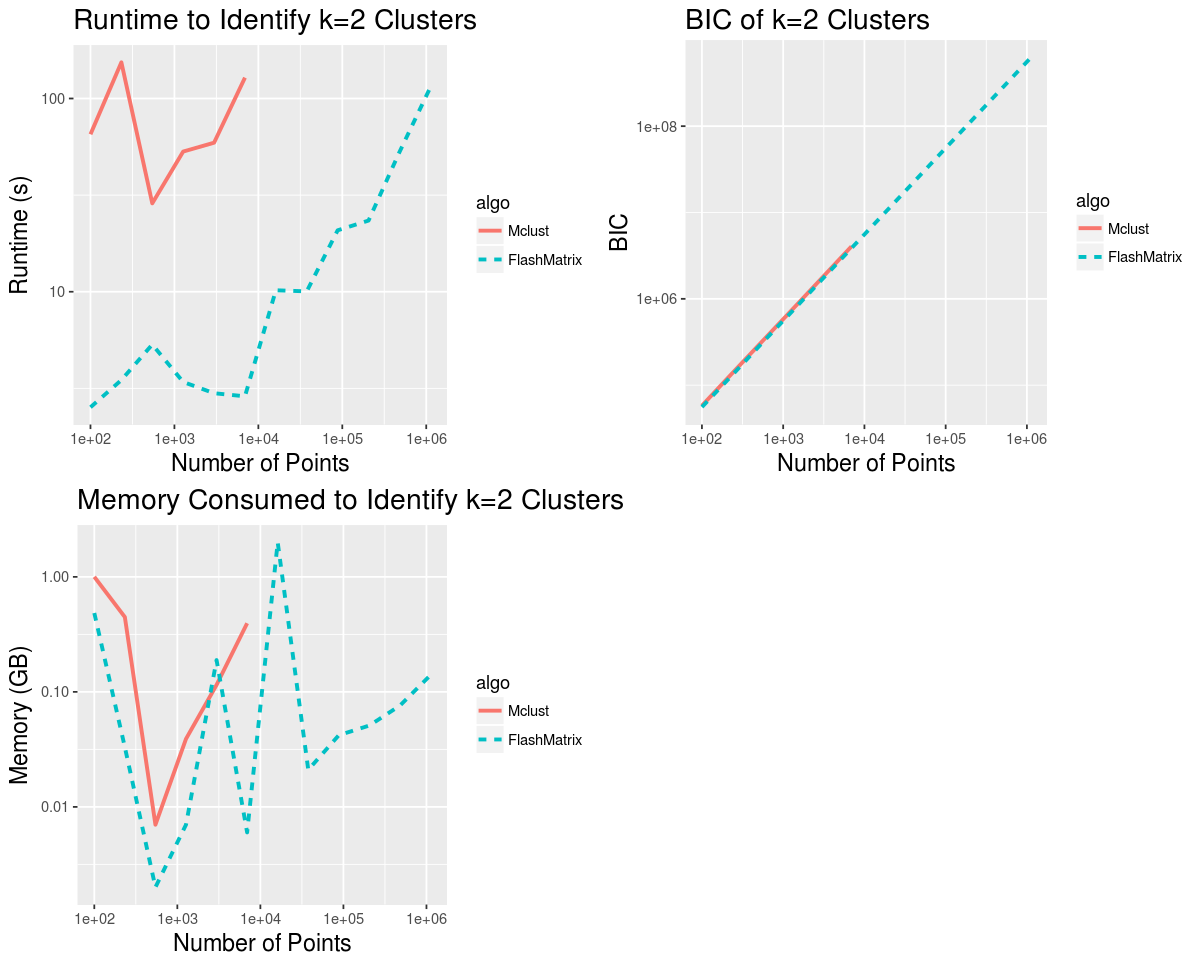

In [12]:
options(repr.plot.height=8, repr.plot.width=10)
require(ggplot2)
require(Rmisc)
baseout_path <- '/tmp/'
runtime <- rbind(data.frame(algo="Mclust", n=ns, bic=abs(results.mc.bic), time=results.mc.time, mem=results.mc.mem), 
                 data.frame(algo="FlashMatrix", n=ns, bic=abs(results.fm.bic), time=results.fm.time, mem=results.fm.mem))

file <- paste(baseout_path, 'time.png', sep="")
png(file, width=600, height=400)
time_plot <- ggplot(runtime, aes(x=n, y=time, color=algo, linetype=algo)) +
    geom_line(size=1.1) +
    scale_x_log10(breaks=lseq(100, 1000000, length.out = 5)) +
    scale_y_log10() +
    xlab('Number of Points') +
    ylab('Runtime (s)') +
    ggtitle('Runtime to Identify k=2 Clusters') +
    theme(axis.title=element_text(size=14), plot.title=element_text(size=17))
print(time_plot)
dev.off()

file <- paste(baseout_path, 'mem.png', sep="")
png(file, width=600, height=400)
mem_plot <- ggplot(runtime, aes(x=n, y=mem, color=algo, linetype=algo)) +
    geom_line(size=1.1) +
    scale_x_log10(breaks=lseq(100, 1000000, length.out = 5)) +
    scale_y_log10() +
    xlab('Number of Points') +
    ylab('Memory (GB)') +
    ggtitle('Memory Consumed to Identify k=2 Clusters') +
    theme(axis.title=element_text(size=14), plot.title=element_text(size=17))
print(mem_plot)
dev.off()

file <- paste(baseout_path, 'bic.png', sep="")
png(file, width=600, height=400)
bic_plot <- ggplot(runtime, aes(x=n, y=bic, color=algo, linetype=algo)) +
    geom_line(size=1.1) +
    scale_x_log10(breaks=lseq(100, 1000000, length.out = 5)) +
    scale_y_log10() +
    xlab('Number of Points') +
    ylab('BIC') +
    ggtitle('BIC of k=2 Clusters') +
    theme(axis.title=element_text(size=14), plot.title=element_text(size=17))
print(bic_plot)
dev.off()

multiplot(time_plot, mem_plot, bic_plot, cols=2)

# Cluster Identification

In this section, we look at a single example where we try to identify $k=8$ clusters from the data using Gaussian Mixture Modeling. In this way, we demonstrate how FlashX could be used to enable the clustering of millions of points of data, vastly outperforming the limits of existing GMM implementations such as MClust, which could not even complete under 10 minutes for all 1.2 million synapses we have array-tomography data for. This suggests that FlashX could be used to aid biologists in the identifications of new classes of synapses:

In [13]:
k=2
results <- GMM.fit(fm.data, k=k, cov.type = "diag")  # run with k clusters on all of the data

png 
  2

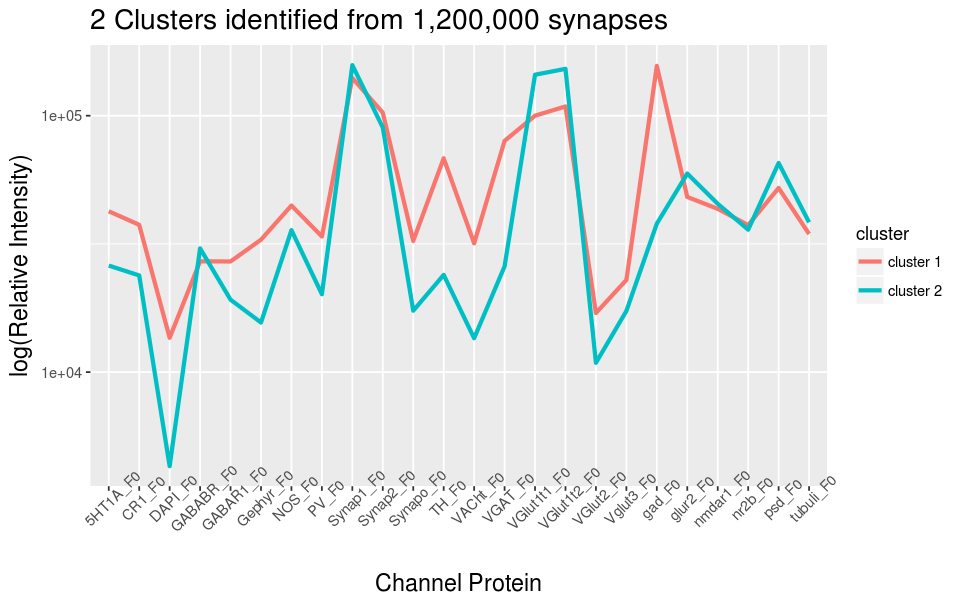

In [14]:
options(repr.plot.height=5, repr.plot.width=8)
require(ggplot2)
require(Rmisc)
mean_dat <- data.frame(cluster=c(), channel=c(), intensity=c())  # we will store our mean data here
channels=colnames(data)  # channels are the names from the h5f object
# build the mean data object for the number of clusters
for (i in 1:k) {
    mean_dat <- rbind(mean_dat, data.frame(cluster=paste("cluster", i),
                                           channel=channels,
                                           intensity=results$parameters$means[i,]))
}

file <- paste(baseout_path, '2cluster_mean.png', sep="")
png(file, width=600, height=400)
syn_mean_plot <- ggplot(mean_dat, aes(x=channel, y=intensity, color=cluster, group=cluster, shape)) +
    geom_line(size=1.2) +
    scale_y_log10() +
    ylab('log(Relative Intensity)') +
    xlab('Channel Protein') +
    ggtitle(paste(k, 'Clusters identified from 1,200,000 synapses')) +
    theme(axis.text.x=element_text(angle=45), axis.title=element_text(size=14), plot.title=element_text(size=17))
print(syn_mean_plot)
dev.off()
print(syn_mean_plot)

In [15]:
k=8
results <- GMM.fit(fm.data, k=k, cov.type = "diag")  # run with k clusters on all of the data

png 
  2

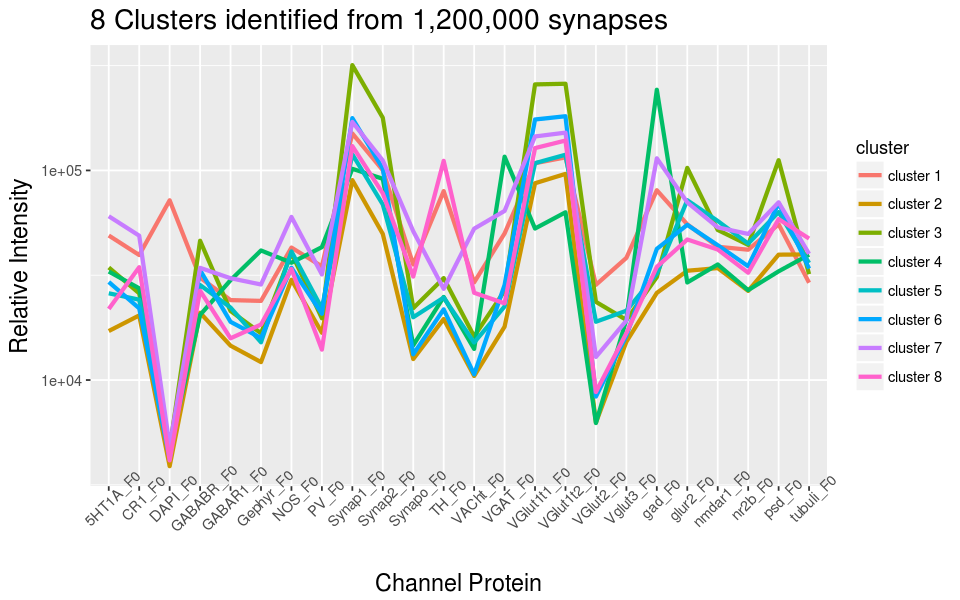

In [17]:
options(repr.plot.height=5, repr.plot.width=8)
mean_dat <- data.frame(cluster=c(), channel=c(), intensity=c())  # we will store our mean data here
channels=colnames(data)  # channels are the names from the h5f object

ch_order = c('Synap1_F0', 'Synap2_F0', 'VGlut1t1_F0', 'VGlut1t2_F0', 'VGlut2_F0', 'VGlut3_F0')
# build the mean data object for the number of clusters
for (i in 1:k) {
    mean_dat <- rbind(mean_dat, data.frame(cluster=paste("cluster", i),
                                           channel=channels,
                                           intensity=results$parameters$means[i,]))
}

file <- paste(baseout_path, '8cluster_mean.png', sep="")
png(file, width=600, height=400)
syn_mean_plot <- ggplot(mean_dat, aes(x=channel, y=intensity, color=cluster, group=cluster)) +
    geom_line(size=1.2) +
    scale_y_log10() +
    ylab('Relative Intensity') +
    xlab('Channel Protein') +
    ggtitle(paste(k, 'Clusters identified from 1,200,000 synapses')) +
    theme(axis.text.x=element_text(angle=45), axis.title=element_text(size=14), plot.title=element_text(size=17))
print(syn_mean_plot)
dev.off()
print(syn_mean_plot)

# Excitatory - Inhibitory Projection

In this section, we look at a random sample of 10,000 synapses projected onto an excitatory protein (VGlut 1T1, a glutamate transport protein) and an inhibitory protein (CR1, an inhibitor of the complement cascade). We color according to the cluster id, and can see that our algorithm effectively clusters some of the data points. This is likely due to the fact that clusters with large numbers of excitatory synapses will show high intensities in the VGlut1T2 fluorescence channel (since VGlut 1T1 is an excitatory glutamate transport protein), while the inhibitory receptors will show high intensities in the CR1 fluorescence channel (since CR1 is an inhibitor of the complement cascade). Intuitively, we would expect that an excitatory synapse would show low intensity in the inhibitory channel, and vice-versa for the inhibitory synapses. As we can see, we end up with a characteristic "spoke" pattern as a result:

png 
  2

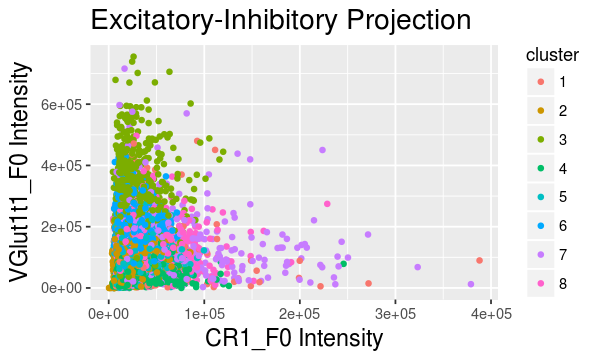

In [18]:
options(repr.plot.height=3, repr.plot.width=5)
n=10000  # 10,000 samples
data <- as.matrix(data)
rsamp <- sample(x=dim(data)[1], size = n)
exc_ch <- 'VGlut1t1_F0'
inh_ch <- 'CR1_F0'

exc <- which(channels == exc_ch)
inh <- which(channels == inh_ch)

cluster_ids <- apply(as.matrix(results$loglik), 1, which.max)

exc_inh_dat <- data.frame(cluster=as.factor(cluster_ids[rsamp]), exc=data[rsamp, exc], inh=data[rsamp, inh])

file <- paste(baseout_path, 'exc_inh_plot.png', sep="")
png(file, width=600, height=400)
exc_inh_plot <- ggplot(exc_inh_dat, aes(x=inh, y=exc, color=cluster, group=cluster)) +
    geom_point(size=1.2) +
    xlab(paste(inh_ch, 'Intensity')) +
    ylab(paste(exc_ch, 'Intensity')) +
    ggtitle('Excitatory-Inhibitory Projection') +
    theme(axis.title=element_text(size=14), plot.title=element_text(size=17))
print(exc_inh_plot)
dev.off()
print(exc_inh_plot)

# Excitatory - Excitatory Projection


In this section, we look at a random sample of 10,000 synapses projected onto an excitatory protein (VGlut 1T2, a glutamate transport protein) and another excitatory protein (PSD, an excitatory post-synaptic protein). Here, we see less of a spoke pattern, and more of "fan" pattern. This is likely due to the fact that clusters with large numbers of excitatory synapses will show higher intensities in both VGlut 1T2 and PSD fluorescence channel (since both are excitatory proteins), while the inhibitory receptors will show lower intensities in both channels:

png 
  2

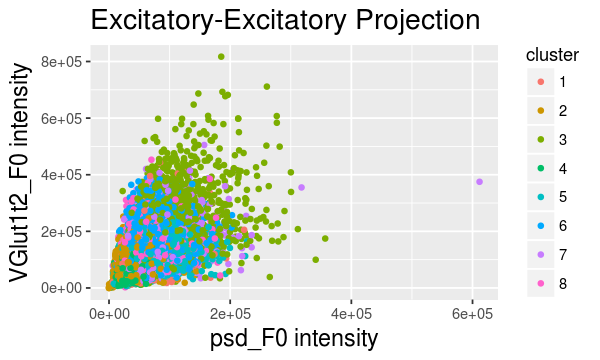

In [19]:
options(repr.plot.height=3, repr.plot.width=5)
n=10000  # 10,000 samples
data <- as.matrix(data)
rsamp <- sample(x=dim(data)[1], size = n)
exc_ch <- 'VGlut1t2_F0'
exc2_ch <- 'psd_F0'

exc <- which(channels == exc_ch)
inh <- which(channels == exc2_ch)

cluster_ids <- apply(as.matrix(results$loglik), 1, which.max)

exc_exc_dat <- data.frame(cluster=as.factor(cluster_ids[rsamp]), exc=data[rsamp, exc], exc2=data[rsamp, exc2_ch])

file <- paste(baseout_path, 'exc_exc_plot.png', sep="")
png(file, width=600, height=400)
exc_exc_plot <- ggplot(exc_exc_dat, aes(x=exc2, y=exc, color=cluster, group=cluster)) +
    geom_point(size=1.2) +
    xlab(paste(exc2_ch, 'intensity')) +
    ylab(paste(exc_ch, 'intensity')) +
    ggtitle('Excitatory-Excitatory Projection') +
    theme(axis.title=element_text(size=14), plot.title=element_text(size=17))
print(exc_exc_plot)
dev.off()

print(exc_exc_plot)